In [2]:
%matplotlib inline

In [3]:
location="psi"

In [ ]:
import sys

#add xgboost
sys.path += ["/mnt/t3nfs01/data01/shome/jpata/xgboost/python-package"]

import copy
from collections import OrderedDict

#add CMSCSTagger
if location=="jpata-macbook":
    sys.path.append("/Users/joosep/Documents/btv/CMSSW_7_4_5/src/RecoBTag/CombinedMVA/python/")
elif location=="psi":
    sys.path.append("/mnt/t3nfs01/data01/shome/jpata/btv/CMSSW_8_1_0_pre8/src/RecoBTag/CMSCSTagger/python/")

import numpy as np
import root_numpy as rnpy
import pandas
import dask

from matplotlib.colors import LogNorm
import rootpy
import rootpy.plotting

import sklearn
from sklearn import metrics
from sklearn.model_selection import KFold, ShuffleSplit

import ROOT

import matplotlib.pyplot as plt
import seaborn

import xgboost

import rootpy.plotting.root2matplotlib as rplt

import sklearn_cls

from pandas.tools.plotting import scatter_matrix

Welcome to ROOTaaS 6.06/08


/swshare/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [ ]:
fn = "/mnt/t3nfs01/data01/shome/jpata/btv/CMSSW_8_1_0_pre8/src/RecoBTag/CMSCSTagger/root_data/project/ttjets.root"
dd = pandas.concat([sklearn_cls.preprocess(sklearn_cls.load_data(
    "/mnt/t3nfs01/data01/shome/jpata/btv/CMSSW_8_1_0_pre8/src/RecoBTag/CMSCSTagger/root_data/project/ttjets.root",
    "tree_{0}".format(fl),
    selection="index>=8"
    #start=0,
    #stop=500000
    )) for fl in ["b", "c", "l"]])
unique_classes = dd["flavour_category"].unique()
#reshuffle
#dd.reindex(np.random.permutation(dd.index))

In [ ]:
dd["flavour_category"].value_counts()

In [ ]:
dd["is_training"].value_counts()

Let's take a quick look at what we have.

In [7]:
dd.head()

,Jet_jetIndex,Jet_pt,Jet_genpt,Jet_eta,Jet_phi,Jet_mass,Jet_flavour,Jet_nbHadrons,Jet_JP,Jet_JBP,...,TagVarCSV_trackEtaRel_2,TagVarCSV_trackEtaRel_3,index,flavour_category,is_training,weight,ptbin,ptbin2,etabin,etabin2
0,24,70.025131,92.493530,-0.207714,2.883270,7.937699,5.0,1.0,0.812475,3.563519,...,-99.000000,-99.000000,8,2,True,1.0,4,6,4,1
1,30,94.247475,83.899406,-1.123851,1.514257,11.192791,5.0,1.0,1.395397,6.536011,...,3.760326,3.679034,9,2,False,1.0,5,7,18,5
2,56,39.067734,29.610649,1.018791,1.194164,9.883041,5.0,1.0,0.356700,1.528618,...,2.525080,2.793700,8,2,True,1.0,2,2,17,5
3,64,103.536194,113.493416,0.980046,-2.710929,13.480186,-5.0,1.0,-0.000000,0.261046,...,-99.000000,-99.000000,9,2,False,1.0,6,8,16,4
4,84,54.714539,45.359280,1.768257,-1.739697,11.201765,5.0,1.0,0.015257,0.842953,...,-99.000000,-99.000000,8,2,True,1.0,3,4,29,8


Now we calculate the kinematic weights.

In [8]:
weights_class = {
    fl: sklearn_cls.get_weights(dd.ix[dd["flavour_category"] == fl], sklearn_cls.ptbins, sklearn_cls.etabins)
    for fl in unique_classes
}

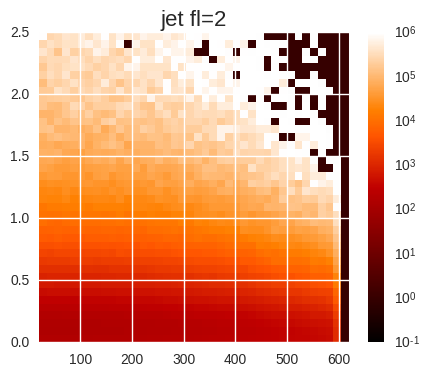

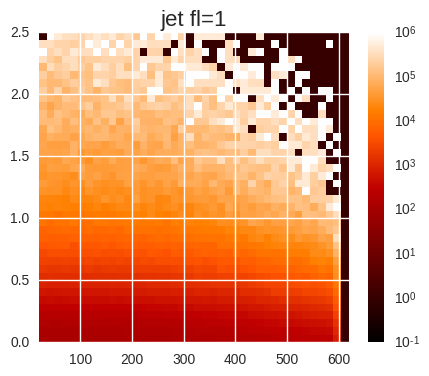

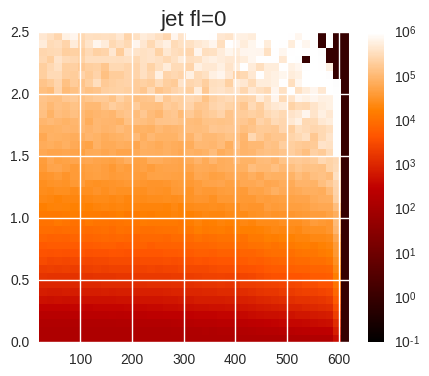

In [9]:
for fl in unique_classes:
    plt.figure(figsize=(5, 4))
    plt.title("jet fl={0}".format(fl), fontsize=16)
    z = plt.imshow(
        weights_class[fl],
        interpolation="none",
        origin="lower",
        norm=LogNorm(vmin=0.1,vmax=1000000.0),
        cmap="gist_heat",
        extent=(sklearn_cls.ptbins[0], sklearn_cls.ptbins[-1], sklearn_cls.etabins[0], sklearn_cls.etabins[-1]),
        aspect="auto"
    )
    plt.colorbar(z)
    #plt.xticks(ptbins)
    #plt.yticks(etabins)

In [10]:
def weight(pt, eta, fl, weights_class, ptbins, etabins):
    ibx = ptbins.searchsorted(pt) - 1
    iby = etabins.searchsorted(abs(eta)) - 1
    if ibx>=len(ptbins)-1:
        ibx = len(ptbins)-2
    if iby>=len(etabins)-1:
        iby = len(etabins)-2
        
    return weights_class[fl][ibx, iby]  

In [11]:
dd["weight"]  = map(
    lambda _z: weight(_z[0], _z[1], _z[2], weights_class, sklearn_cls.ptbins, sklearn_cls.etabins),
    zip(dd["Jet_pt"], dd["Jet_eta"].abs(), dd["flavour_category"])
)

In [12]:
def draw_corr(data, v1, vn1, v2, vn2, title):

    c = (np.abs(data["Jet_CSV"] -
         data["Jet_CSVIVF"])>0.00000000001
    )
    hd = np.histogram2d(
        data[c][v1],
        data[c][v2],
        bins=[np.linspace(0,1,21), np.linspace(0,1,21)]
    )
    hd = hd[0] / float(np.sum(hd[0]))
    corr = np.corrcoef(
        data[c][v1],
        data[c][v2]
    )

    plt.figure(figsize=(6,5))
    ax = plt.axes()
    ret = ax.imshow(
        hd,
        cmap="hot",
        interpolation="none",
        origin="lower",
        aspect="auto",
        #vmin=0,
        #vmax=60000,
        extent=[
            0,
            1,
            0,
            1
        ],
        norm=LogNorm(vmin=0.000001, vmax=1)
    )
    plt.title(title + " corr={0:.4f}".format(corr[0,1]), fontsize=16)
    plt.xlabel(vn1, fontsize=16)
    plt.ylabel(vn2, fontsize=16)
    plt.colorbar(ret)

Pt distribution before and after reweighting.

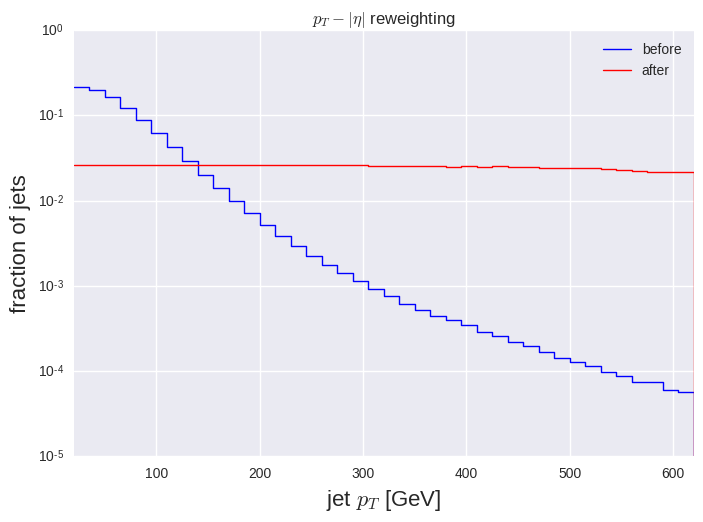

In [13]:
h = rootpy.plotting.Hist(sklearn_cls.ptbins)
w = np.ones(len(dd), dtype="float64")
h.FillN(len(dd), np.array(dd["Jet_pt"]).astype("float64"), w)
h.Scale(1.0 / h.Integral())
h.color="blue"
rplt.hist(h, color="blue", label="before")

h2 = rootpy.plotting.Hist(sklearn_cls.ptbins)
h2.FillN(len(dd), np.array(dd["Jet_pt"]).astype("float64"), np.array(dd["weight"]).astype("float64"))
h2.Scale(1.0 / h2.Integral())
h2.color="red"
rplt.hist(h2, color="red", label="after")

plt.yscale("log")
plt.ylim(10**-5, 1)
plt.xlabel("jet $p_T$ [GeV]", fontsize=16)
plt.ylabel("fraction of jets", fontsize=16)
plt.legend()
plt.title("$p_T-|\eta|$ reweighting")
plt.savefig("pt_reweight.pdf")

Eta distribution before and after reweighting.

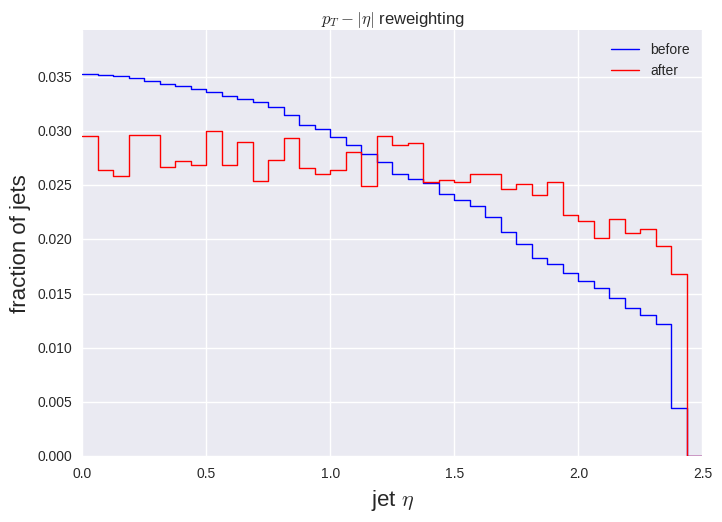

In [14]:
h = rootpy.plotting.Hist(sklearn_cls.etabins)
w = np.ones(len(dd), dtype="float64")
h.FillN(len(dd), np.array(dd["Jet_eta"]).astype("float64"), w)
h.Scale(1.0 / h.Integral())
h.color="blue"
rplt.hist(h, color="blue", label="before")

h2 = rootpy.plotting.Hist(sklearn_cls.etabins)
h2.FillN(len(dd), np.array(dd["Jet_eta"]).astype("float64"), np.array(dd["weight"]).astype("float64"))
h2.Scale(1.0 / h2.Integral())
h2.color="red"
rplt.hist(h2, color="red", label="after")

#plt.yscale("log")
#plt.ylim(10**-5, 1)
plt.xlabel("jet $\eta$", fontsize=16)
plt.ylabel("fraction of jets", fontsize=16)
plt.legend()
plt.title("$p_T-|\eta|$ reweighting")
plt.savefig("eta_reweight.pdf")

In [15]:
vs = ["Jet_CSV", "Jet_CSVIVF", "Jet_JP", "Jet_JBP", "Jet_SoftMu", "Jet_SoftEl"]

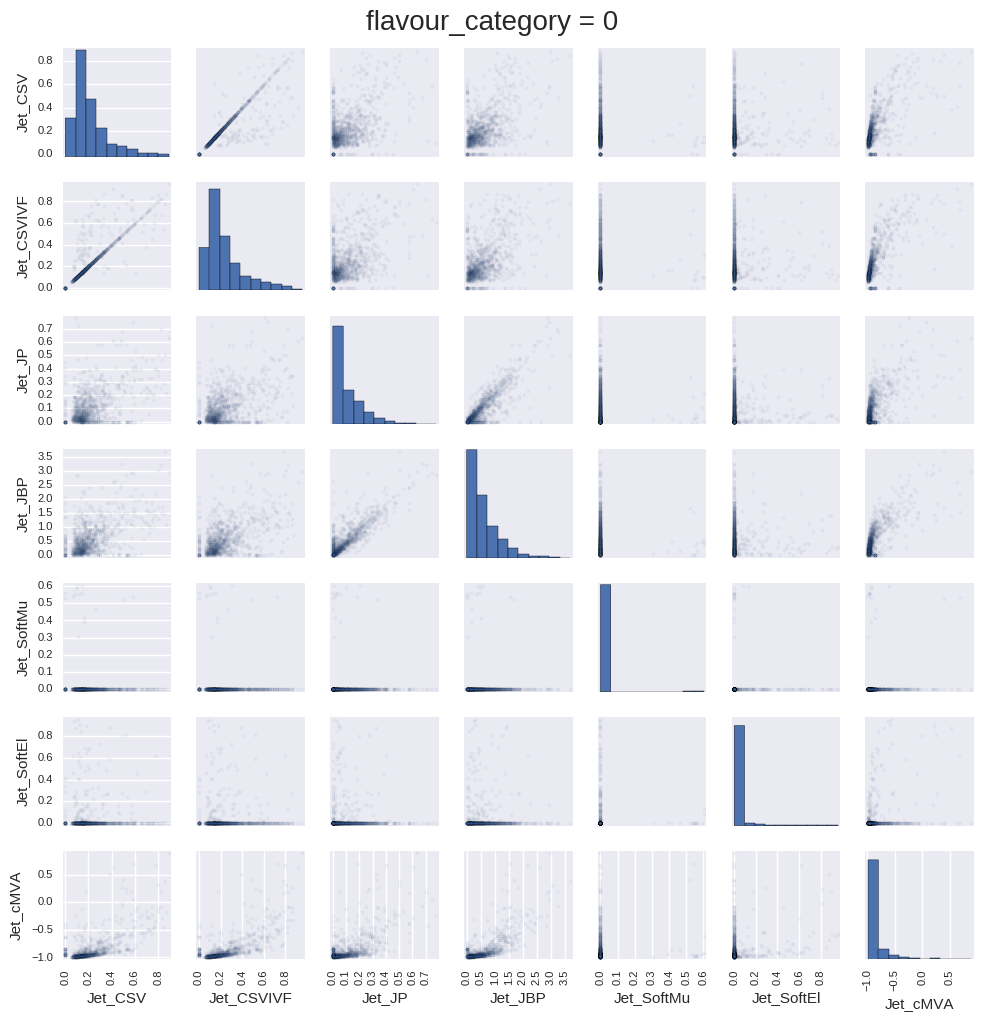

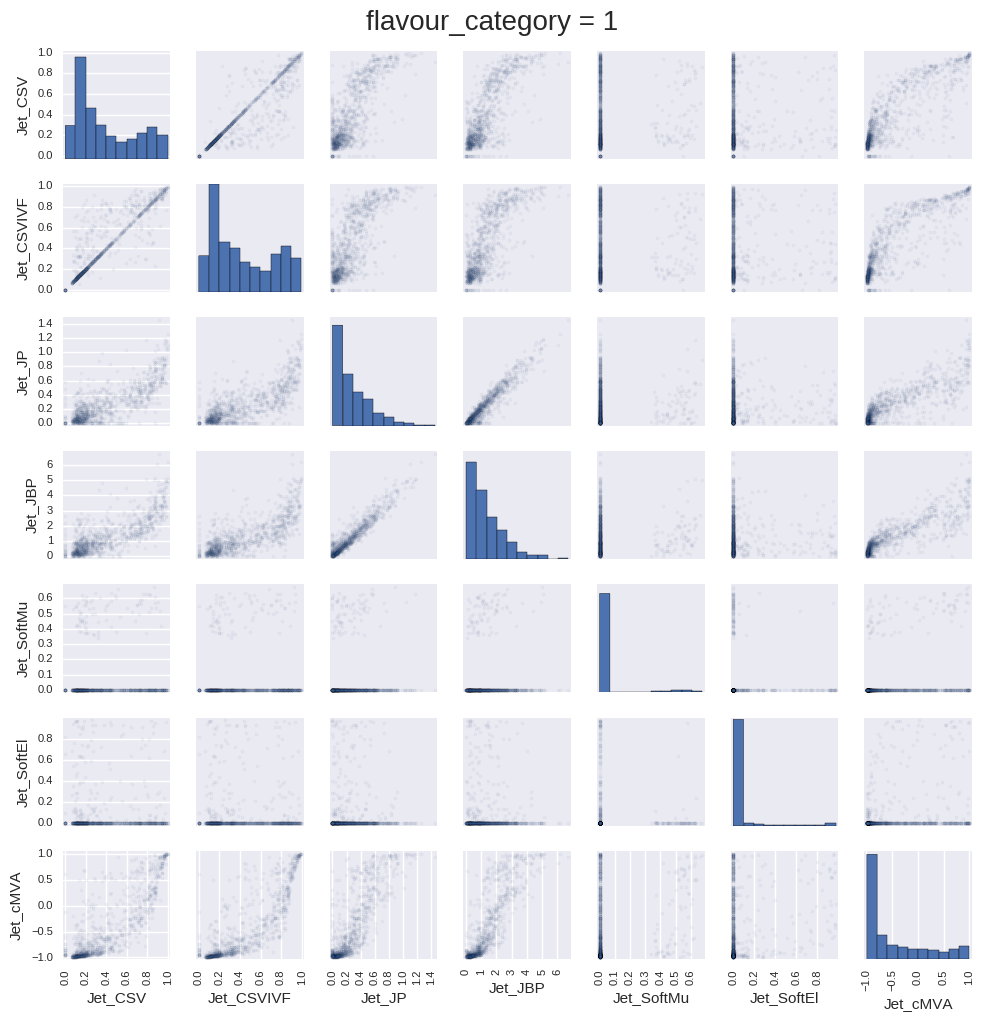

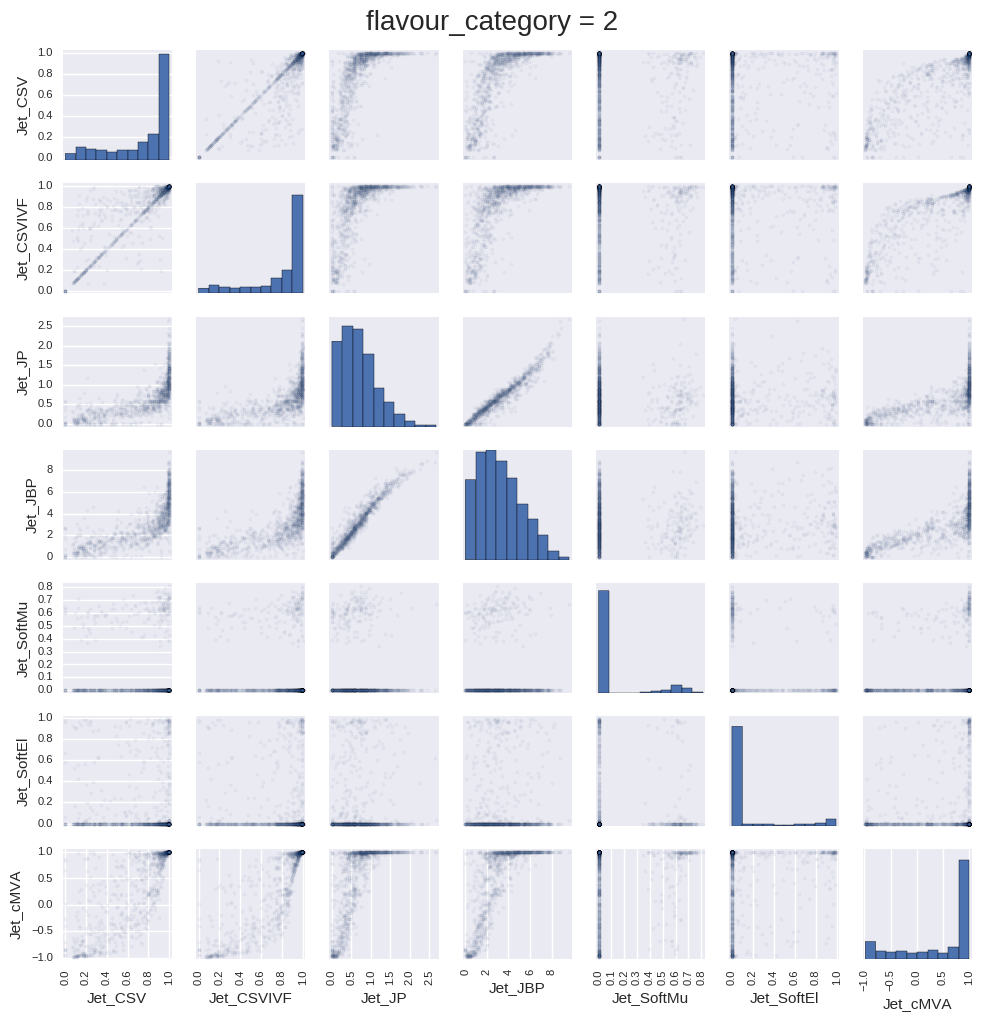

In [16]:
for igroup, (name, group) in enumerate(dd.groupby("flavour_category")):
    scatter_matrix(group.head(1000)[vs + ["Jet_cMVA"]], alpha=0.05, figsize=(10, 10), diagonal='hist')
    seaborn.plt.suptitle("flavour_category = {0}".format(name), fontsize=20, y=1.02)
    seaborn.plt.tight_layout()

In [17]:
is_training = dd["is_training"]==1

In [18]:
eval_set = [
    (dd.ix[is_training, vs], dd.ix[is_training, "flavour_category"]==2),
    (dd.ix[np.invert(is_training), vs], dd.ix[np.invert(is_training), "flavour_category"]==2)
]

In [19]:
vs2 = filter(lambda x: "TagVar" in x, dd.columns) + ["Jet_JP", "Jet_JBP", "Jet_SoftMu", "Jet_SoftEl"] + ["Jet_pt", "Jet_eta"]
eval_set2 = [
    (dd.ix[is_training, vs2], dd.ix[is_training, "flavour_category"]==2),
    (dd.ix[np.invert(is_training), vs2], dd.ix[np.invert(is_training), "flavour_category"]==2)
]

In [20]:
dd.groupby(["flavour_category", "is_training"]).apply(lambda x: len(x))

flavour_category  is_training
0                 False          1901962
                  True           1901962
1                 False           526835
                  True            526837
2                 False          1409275
                  True           1409276
dtype: int64

In [21]:
cls = xgboost.XGBClassifier(n_estimators=500, nthread=32)

In [22]:
cls.fit(eval_set[0][0], eval_set[0][1], eval_set=eval_set, eval_metric=["error"], verbose=False)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, nthread=32,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [23]:
cls2 = xgboost.XGBClassifier(n_estimators=500, nthread=32)
cls2.fit(eval_set2[0][0], eval_set2[0][1], eval_set=eval_set2, eval_metric=["error"], verbose=True)

[0]	validation_0-error:0.156924	validation_1-error:0.156925
[1]	validation_0-error:0.155011	validation_1-error:0.155024
[2]	validation_0-error:0.153897	validation_1-error:0.153962
[3]	validation_0-error:0.153238	validation_1-error:0.153214
[4]	validation_0-error:0.152577	validation_1-error:0.152563
[5]	validation_0-error:0.151008	validation_1-error:0.150965
[6]	validation_0-error:0.150974	validation_1-error:0.150935
[7]	validation_0-error:0.150954	validation_1-error:0.150987
[8]	validation_0-error:0.150771	validation_1-error:0.150837
[9]	validation_0-error:0.1506	validation_1-error:0.150632
[10]	validation_0-error:0.150286	validation_1-error:0.150322
[11]	validation_0-error:0.148781	validation_1-error:0.148743
[12]	validation_0-error:0.148141	validation_1-error:0.14822
[13]	validation_0-error:0.147564	validation_1-error:0.147655
[14]	validation_0-error:0.147145	validation_1-error:0.147189
[15]	validation_0-error:0.146588	validation_1-error:0.146738
[16]	validation_0-error:0.145944	vali

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, nthread=32,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [30]:
fpr_main, tpr_main, _ = sklearn.metrics.roc_curve(
    eval_set[0][1],
    cls.predict_proba(eval_set[0][0])[:, 1]
)
res_main = cls.evals_result()

In [31]:
dd["cls_p1"] = cls.predict_proba(dd[vs])[:, 1]
# dd["cls2_p2"] = dd_cls[:, 2]

In [32]:
dd["cls2_p1"] = cls2.predict_proba(dd[vs2])[:, 1]

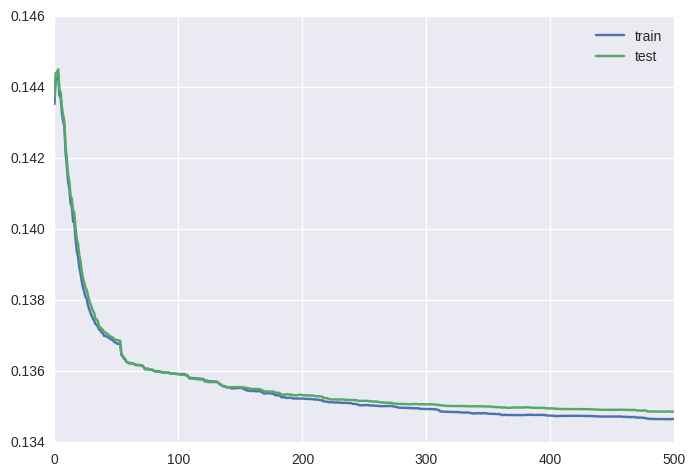

In [33]:
plt.plot(res_main["validation_0"]["error"], label="train")
plt.plot(res_main["validation_1"]["error"], label="test")
plt.legend()

In [ ]:
rets_cv = sklearn_cls.train_crossvalidation(cls, eval_set[0])

In [ ]:
plt.figure(figsize=(4,4))
for tpr, fpr in rets_cv:
    plt.plot(tpr, fpr, color="black", lw=1, alpha=0.3)
plt.plot(tpr_main, fpr_main, color="black", lw=2)
aucs = np.array([sklearn.metrics.auc(tpr, fpr) for (tpr, fpr) in rets_cv])
print aucs
plt.title("AUC\nmean={0:.4E}\nstd={1:.4E}".format(np.mean(aucs), np.std(aucs)))
plt.yscale("log")
plt.xlim(0.5, 1.0)
plt.ylim(0.01, 1.0)

In [ ]:
rets_varremove = sklearn_cls.train_variable_remove(cls, eval_set[0], eval_set[1])

In [ ]:
plt.figure(figsize=(6,6))
plt.title("discrimination with removing one variable")
for (tpr, fpr), var in zip(rets_varremove[0], rets_varremove[1]):
    plt.plot(tpr, fpr, label="{0} AUC={1:.4f}".format(var, sklearn.metrics.auc(tpr, fpr)), lw=1)

plt.plot(
    tpr_main,
    fpr_main,
    color="black",
    lw=2,
    label="{0} AUC={1:.4f}".format(
        "total", sklearn.metrics.auc(tpr_main, fpr_main))
    )
plt.yscale("log")
plt.xlim(0.5, 1.0)
plt.ylim(0.01, 1.0)
ts = np.logspace(-2, 0, 21)
plt.yticks(ts, [round(x, 3) for x in ts])
plt.legend(loc="best")

In [34]:
def compare_classes(c1, c2, dd, probas):
    is_c1 = dd["flavour_category"] == c1
    is_c2 = dd["flavour_category"] == c2
    rocs = []
    for cls_proba in probas:
        fpr, tpr, _ = sklearn.metrics.roc_curve(
            dd.loc[is_c1|is_c2, "flavour_category"] == c1,
            dd.loc[is_c1|is_c2, cls_proba]
        )
        rocs += [(fpr, tpr, cls_proba)]
    return rocs

In [35]:
pairs = []
for c1 in unique_classes:
    for c2 in unique_classes:
        if c1 == c2:
            continue
        if (c1, c2) in pairs or (c2, c1) in pairs:
            continue
        pairs += [(c1, c2)]

In [36]:
rocs = []
for p in pairs:
    rocs += [
        (p, compare_classes(p[0], p[1], dd[dd["is_training"]==0], ["Jet_CSVIVF", "Jet_cMVA", "cls_p1", "cls2_p1"]))
    ]

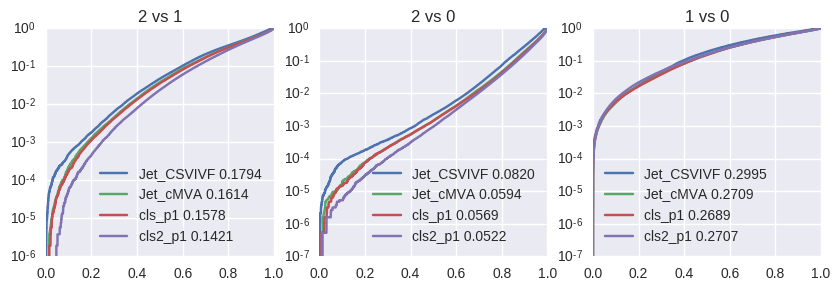

In [37]:
plt.figure(figsize=(10, 10))

ipl = 1
for pair, roc in rocs:
    plt.subplot(3, 3, ipl)
    for fpr, tpr, label in roc:
        plt.plot(tpr, fpr, label=label + " {0:.4f}".format(sklearn.metrics.auc(tpr, fpr)))
    plt.title("{0} vs {1}".format(pair[0], pair[1]))
    plt.yscale("log")
    #plt.xlim(0.5, 1.0)
    #plt.ylim(0.001, 1.0)
    plt.legend(loc="best")
    ipl += 1

In [42]:
def get_auc_by_group(c1, c2, discs, col):
    vals = {d: [] for d in discs}
    vals_err = {d: [] for d in discs}
    for grname, gr in dd[dd["is_training"]==0].groupby(col):
        kf = ShuffleSplit(n_splits = 10, test_size=0.2)
        vals_bin = {d: [] for d in discs}
        for train, test in kf.split(dd.index):
            rocs = compare_classes(c1, c2, gr.ix[train], discs)
            for disc, r in zip(discs, rocs):
                vals_bin[disc] += [sklearn.metrics.auc(r[1], r[0])]
        for d in discs:
            vals[d] += [np.mean(vals_bin[d])]
            vals_err[d] += [np.std(vals_bin[d])]
    return vals, vals_err

In [ ]:
discs = ["Jet_CSVIVF", "Jet_cMVA", "cls_p1"]
vals, vals_err = get_auc_by_group(2, 1, discs, "ptbin2")
for d in discs:
    plt.errorbar(sklearn_cls.ptbins2, vals[d], yerr=vals_err[d], label=d)
plt.legend()
plt.xlabel("pt")
plt.ylabel("AUC")

In [ ]:
discs = ["Jet_CSVIVF", "Jet_cMVA", "cls_p1"]
vals, vals_err = get_auc_by_group(2, 0, discs, "ptbin2")
for d in discs:
    plt.errorbar(sklearn_cls.ptbins2, vals[d], yerr=vals_err[d], label=d)
plt.legend()
plt.xlabel("pt")
plt.ylabel("AUC")

In [ ]:
discs = ["Jet_CSVIVF", "Jet_cMVA", "cls_p1"]
vals, vals_err = get_auc_by_group(2, 1, discs, "etabin2")
for d in discs:
    plt.errorbar(sklearn_cls.etabins2, vals[d], yerr=vals_err[d], label=d)
plt.legend()
plt.xlabel("pt")
plt.ylabel("AUC")

In [ ]:
discs = ["Jet_CSVIVF", "Jet_cMVA", "cls_p1"]
vals, vals_err = get_auc_by_group(2, 0, discs, "etabin2")
for d in discs:
    plt.errorbar(sklearn_cls.etabins2, vals[d], yerr=vals_err[d], label=d)
plt.legend()
plt.xlabel("pt")
plt.ylabel("AUC")